# Methylation and accessibility prediction on S3 

25/02/13

This notebook intakes pickle files previously generated by extractIPDfull3.py.
The pickle files contain the mean log10IPDs for each base for each consensus read. 

This notebook uses the pickle files to train an SVD model, which generates a decomposed encoding of the ~3500bp DNA molecules into 40 normalized pc variables based on non-A ipds 

The neural network model intakes this SVD decomposed encoding along with the A ipds and the indices of the Aipds along the ~3500bp molecule

The neural network trains on aIPDs in the negative control (unmethylated DNA) and generates predictions for the IPD of each adenine if it were unmethylated. Then it subtracts the prediction from the measured aIPD, and saves the residuals. For the negative control, these residuals should be zero.

The neural network is then run on the positive control (all methylated DNA) and predictions for unmethylated aIPDs are again subtracted from measured aIPDs. This time, the residuals should be > 0 for many adenines, because methylated adenines generate larger IPDs than unmethylated adenines. 

A student's t-mixture model is then run on the residuals from the positive and negative controls in order to determine the means + other statistics of two residual populations for each adenine. Ideally, there should be a clear separation between the two population means so that you can determine whether a particular adenine is methylated given its IPD residual (aka does this residual belong to the residual population from the positive control or the negative control?)
Not all adenines will have two discernable populations, so a threshold is applied to each adenine and only the adenines with good enough separation between the two residual population means are selected to make methylation predictions.
After thresholding, the methylation predictions are binarized as methylated or unmethylated. 

Next, a hidden markov model is used to infer accessibility states at these good adenines given the methylation states. More detailed info the markov model is below, but the general idea here is that accessibility is not identical to methylation state (an unmethylated A in a series of methylated As is likely accessible). 

Finally, np.interp() interpolates accessibility across the entire ~3500bp molecule given the inferred accessibility of the good adenines. The interpolation is linear. 

After all of this initializing, you are finally ready to run your chromatin samples! 
The chromatin samples are processed slightly differently: the IPDs are extracted directly from CCS (version 6.9.99) files as 50lnIPD + 1 and transformed into log10IPDs like the controls.
After extraction, IPDs are run throgh the SVD model and NNmodel, and residuals of aIPDs at the good A indices are then passed through the thresholds determined by the t-mixture model and called as methylated or not. 
The hidden markov model is used to infer accessibility states at the good adenines and accessibility is linearly interpolated across the entire ~3500bp molecule given the inferred acessibility of the good adenines. Theses numpy arrays are saved and analyzed further in a different notebook: "Hmm_output_analysis"


In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from tqdm import tqdm
import pickle
import os
from Bio import Seq, SeqIO
import socket

from sklearn.decomposition import TruncatedSVD
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

refFile = '/home/cmoore/sequences/Cyp3a11_reference.fasta' #shortedned ref bc im an idiot
for ir, record in enumerate(SeqIO.parse(refFile, 'fasta')):
    if ir > 0:
        raise InputError('Reference fasta has multiple entries')
    refseq = record.seq 


### Use dimensionality reduction to capture features of the molecules. Write out as NN input

In [2]:
# Makes NN formated input data for amplicon molecules
# If svdmodel is not passed, it trains the PCA model on the sample given. So give it the negative control first.
# It will return the trained model, which you can then pass for subsequent runs on other samples

#the NN takes the SVD decomposed encoding of the amplicons based on non-A ipds in normalized pc variables, the A ipds, and the A indices

def latentifyMakeNNinput(fin, refseq, svdmodel=None):
    ipds = fin
    with open(fin, 'rb') as fin:
        ipds = pickle.load(fin, encoding="latin1") #load in controls 
    
    refis = {n: np.array([b is n for b in refseq]) for n in ['A','C','G','T']}
    
    notaFor = np.logical_or.reduce([refis['A'],refis['C'],refis['G']]) #all bases that were not A on template
    notaRev = np.logical_or.reduce([refis['T'],refis['C'],refis['G']]) #all bases that were not A on template
    nfor = np.sum(notaFor)
    nrev = np.sum(notaRev)

    notaipd = np.full((len(ipds), (nfor + nrev)), np.nan, dtype=np.float32)

    for i in range(len(ipds)):
        notaipd[i, 0:nfor] = ipds[i]['fmean'][notaFor] #mean is interchangable with ipd, mean of subreads
        notaipd[i, nfor:(nfor+nrev)] = ipds[i]['rmean'][notaRev] #plot histogram of ipds at these bases for template_A=refis['T'] 
        
        #ipds[i]['fmean'][refis['T']] subset of fmean where ref is a T
    notaipd = notaipd - np.nanmean(notaipd, axis=0) #each ipd has the molecule's mean ipd subtracted from it
    indices = np.nonzero(~np.isnan(notaipd)) #returns indices of ipds that are nonzero
    
    #make an empty sparse coordinate matrix
    
    sparsem = coo_matrix( (notaipd[indices], indices), shape=notaipd.shape) 
    
    sparsem = csr_matrix(sparsem)
    
    if svdmodel is None: #training: fit the model to the sparse matrix before transforming the matrix with the 40 variables
        svdmodel = TruncatedSVD(n_components=40, n_iter=20, random_state=33) #works on sparse data with missing measurements
        svdmodel.fit(sparsem)
        pcvars = svdmodel.transform(sparsem)
    else:
        pcvars = svdmodel.transform(sparsem) #keep variables consistent now that model is trained
        
    stpcvars = pcvars - pcvars.mean(axis=0) 
    stpcvars = stpcvars / stpcvars.std(axis=0)   #normalized variables
    
    onlyATref = [b for b in refseq if b == 'A' or b == 'T']
    refisonly = {n: np.array([b is n for b in onlyATref]) for n in ['A','T']}

    aipd = np.full((len(ipds), len(onlyATref)), np.nan, dtype=np.float32) #just the adenines, adenine ipds. No longer linked to sequence index
    for i in range(len(ipds)):
        aipd[i, refisonly['T']] = ipds[i]['fmean'][refis['T']]
        aipd[i, refisonly['A']] = ipds[i]['rmean'][refis['A']]
    
    abaseInd = np.nonzero(np.logical_or(refis['A'], refis['T']))[0]
    if not os.path.exists(dataPBase + 'forNN') :
        os.makedirs(dataPBase + 'forNN')
        
    return svdmodel, abaseInd

In [ ]:
#only need to run once while training model
#generate the SVD model, which is the NNinput

dataPBase = '/home/cmoore/results/pacbio/211101_CM_Cyp3a11_HP1_rep2/'
samp = '211101_NakedCyp3a11_noM' # the independent site naked unmethylated control
isvdmod, negabaseInd = latentifyMakeNNinput('/home/cmoore/results/pacbio/211101_CM_Cyp3a11_HP1_rep2/pickles/211101_CM_Cyp3a11_HP1_rep2_NakedCyp3a11_noM_full.pickle', refseq)

#now do positive control
samp = '211101_NakedCyp3a11_m'
isvdmod, posabaseInd = latentifyMakeNNinput('/home/cmoore/results/pacbio/211101_CM_Cyp3a11_HP1_rep2/pickles/211101_CM_Cyp3a11_HP1_rep2_NakedCyp3a11_m_full.pickle', refseq, isvdmod)
 

In [ ]:
#only need to run once while training model
#save the svdmodel

outputModels = dataPBase +'trained_models/'

with open(outputModels + 'S3_svdmodel.p', 'wb') as svd_model_file:
    # Dump the model into the file
    pickle.dump(isvdmod, svd_model_file)

    

In [3]:
#load svd model
dataPBase = '/home/cmoore/results/pacbio/211101_CM_Cyp3a11_HP1_rep2/'
trainedModel = dataPBase +'trained_models/'

with open(trainedModel + 'S3_svdmodel.p', 'rb') as fp:
    isvdmod = pickle.load(fp)
print('Number of svd components:', isvdmod.n_components) #should be 40!


Number of svd components: 40


In [4]:
#load the saved ipds

db = '/home/cmoore/results/pacbio/211101_CM_Cyp3a11_HP1_rep2/pickles/'
infile = '211101_CM_Cyp3a11_HP1_rep2_NakedCyp3a11_m_full.pickle'

refFile = '/home/cmoore/Cyp3a11_reference.fasta'
for ir, record in enumerate(SeqIO.parse(refFile, 'fasta')):
    if ir > 0:
        raise InputError('Reference fasta has multiple entries')
    refseq = record.seq # reference sequence for independent CTCF site
    

for ir, record in enumerate(SeqIO.parse(refFile, 'fasta')):
    if ir > 0:
        raise InputError('Reference fasta has multiple entries')
    refseq = record.seq # reference sequence for independent CTCF site
       
    
ipdfull={}
with open(db+infile, 'rb') as fin:
    file = extractIPDfile = pickle.load(fin, encoding="latin1")
    
    for read in file:
        zmw = read["zmw"]
        ipdfull[zmw] = read
        
#get all the aipds in an array

refis = {n: np.array([b is n for b in refseq]) for n in ['A','C','G','T']}
onlyATref = [b for b in refseq if b == 'A' or b == 'T']
refisonly = {n: np.array([b is n for b in onlyATref]) for n in ['A','T']}

aipd = np.full((len(ipdfull.keys()), len(onlyATref)), np.nan, dtype=np.float32) #just the adenines, adenine ipds. No longer linked to sequence index
for i, zmw in enumerate(ipdfull.keys()):
    aipd[i, refisonly['T']] = ipdfull[zmw]['fmean'][refis['T']]
    aipd[i, refisonly['A']] = ipdfull[zmw]['rmean'][refis['A']]
    
pos_aipd = aipd

### Use a neural network regression model to predict the aIPD in the negative control. Then generate predictions for all samples and subtract them from measured aIPD, and save those aIPD residuals

In [5]:
############ Alternate model that predicts all bases at once

# now use the NN to get aIPD residuals

from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

def getResiduals(samp, npzfile, model=None, suffix=''): #model takes in 40 variables from PCA and for every adenine predicts the IPD for the unmethylated control during training

    with np.load(npzfile) as data:
  
        
        aipd = data['aipd']
        pcvars = data['stpcvars']
        #print(aipd[~np.isnan(aipd)], len(aipd[~np.isnan(aipd)]))

    if model is None: #just for training
                    
        pcv_input = keras.layers.Input(shape=pcvars.shape[1:]) #all molecules (rows) except the first one
        lay1 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(pcv_input)
        drop1 = keras.layers.Dropout(0.5)(lay1)
        lay2 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(drop1)
        drop2 = keras.layers.Dropout(0.5)(lay2)
        lay3 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(drop2)
        drop3 = keras.layers.Dropout(0.5)(lay3)
        lay4 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(drop3)
        drop4 = keras.layers.Dropout(0.5)(lay4)
        outputs = keras.layers.Dense(aipd.shape[1])(drop4)
        model = keras.models.Model(inputs=[pcv_input],
                                       outputs=[outputs])
        model.compile(loss="mean_squared_error", optimizer="Adam")
    
        mol = np.nonzero(np.sum(np.isnan(aipd), axis=1) == 0)[0] #A positions where all molecules have a measured IPD
        
        #print('number of molecules with an observed IPD at each position', np.sum(np.isfinite(aipd), axis=0))
        #bogus = np.sum(np.isfinite(aipd), axis=0)
        #print(bogus.shape)
        #plt.figure()
        #plt.plot(np.arange(0,len(bogus)))
        #plt.hist(np.sum(np.isfinite(aipd), axis=0), bins=100)
        #plt.show()
        
        history = model.fit([pcvars[mol,:]], aipd[mol, :],
                            epochs=100, batch_size=128, shuffle=True, verbose=0)

    pred = model.predict(pcvars, batch_size=512) #regardless 
    resid = aipd - pred #residuals
        
  
    np.savez(os.path.join(dataPBase, samp + '_NNresid' + '.npz'),
             residuals = resid)
    
 
    return model


In [ ]:
#only need to run once while training model
#negative control will generate NN and then NN will compute residuals

dataPBase = '/home/cmoore/results/pacbio/211101_CM_Cyp3a11_HP1_rep2/'
samp = '211101_NakedCyp3a11_noM'
imodel = getResiduals(samp, dataPBase + 'forNN/211101_NakedCyp3a11_noM_forNNsimple.npz')
    
# #now pos control, compute residuals 
samp = '211101_NakedCyp3a11_m'
imodel = getResiduals(samp, dataPBase + 'forNN/211101_NakedCyp3a11_m_forNNsimple.npz', imodel)


In [ ]:
# outputModels = dataPBase + 'trained_models/'
# #save that NN model cause it takes too long to redo bro
# imodel.save(outputModels + 'S3_NNmodel.keras')


In [6]:
#load NNmodel 
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf

imodel = tf.keras.models.load_model(dataPBase + 'trained_models/' + 'S3_NNmodel.keras')
imodel.summary() #just to make sure you loaded it in, final dense layer should be number of A/Ts on template


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
dense (Dense)                (None, 600)               24600     
_________________________________________________________________
dropout (Dropout)            (None, 600)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 600)               360600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 600)               360600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 600)               0     

In [ ]:
#only need to run once while training model
dataPBase = '/home/cmoore/results/pacbio/211101_CM_Cyp3a11_HP1_rep2/'
samp = '211101_NakedCyp3a11_noM'
imodel = getResiduals(samp, dataPBase + 'forNN/211101_NakedCyp3a11_noM_forNNsimple.npz', imodel)
    
# #now pos control, compute residuals 
samp = '211101_NakedCyp3a11_m'
imodel = getResiduals(samp, dataPBase + 'forNN/211101_NakedCyp3a11_m_forNNsimple.npz', imodel)

### Mixture model classification

The goal here is the apply a mixture model to the residuals of each adenine to identify the two subpopulations, methylated and unmethylated. This finds the best cutoff between the two, and also is used to filter out adenines for which there is no good cutoff, and which are then excluded from the downstream analysis

In [7]:
#load in the aIPD residuals for positive and negative controls

refis = {n: np.array([b is n for b in refseq]) for n in ['A','C','G','T']}
abaseInd = np.nonzero(np.logical_or(refis['A'], refis['T']))[0]

residuals = []
sampleOr = []

dbase = '/home/cmoore/results/pacbio/211101_CM_Cyp3a11_HP1_rep2/'

with np.load(dbase + '211101_NakedCyp3a11_m_NNresid.npz') as data:
    residuals.append(data['residuals'])
    sampleOr.append(np.full((data['residuals'].shape[0],1), 0))

with np.load(dbase + '211101_NakedCyp3a11_noM_NNresid.npz') as data:
    residuals.append(data['residuals'])
    sampleOr.append(np.full((data['residuals'].shape[0],1), 1))

    

In [8]:
neg_residuals = residuals[1] #negative control
pos_residuals = residuals[0] #positive control


Text(0, 0.5, 'Median residual')

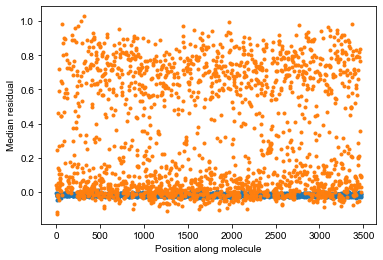

In [9]:
# plot out the median residuals at each adenine in the positive and negative controls

negmed = []
posmed = []

for base in range(residuals[0].shape[1]):
    posmed.append(np.nanmedian(residuals[0][:,base]))
    negmed.append(np.nanmedian(residuals[1][:,base]))
posmed = np.array(posmed)
negmed = np.array(negmed)

plt.plot(abaseInd, negmed, '.')
plt.plot(abaseInd, posmed, '.')
plt.xlabel('Position along molecule')
plt.ylabel('Median residual')

In [ ]:
for b in tqdm(range(0, 30), position=0, smoothing=0):
    
    plt.figure(figsize=(10,2.5))
    plt.title('Adenine %s residuals, meanln(IPD)' % b)

     #look at the ipds for each adenine and the cutoff 
    plt.hist(residuals[0][:,b],  bins=50, range=(-1,2), color='orange') #look at the ipds for each adenine and the cutoff 
    plt.hist(residuals[1][:,b], bins=50, range=(-1,2), color='blue')
    plt.xlabel('Residuals', fontsize=14)
    plt.ylabel('Counts', fontsize=14)

This function trains the student's t mixture model on the residual populations and determines a 'cutoff' IPD value which is closest to having a 50% probability of coming from smm2, the second component. This is not necessarily the methylated distribution. 

In [ ]:
#only need to run once while training model
# t-distribution mixture model for determining means of residual populations for each adenine
#some methylated adenines may not be slower, trying to fit model to what is and is not methylated 

import smm
from scipy.stats import t
import warnings
from sklearn.exceptions import ConvergenceWarning

residuals = [posResiduals, negResiduals]

minmol = min(residuals[0].shape[0], residuals[1].shape[0])
usemol0 = np.random.choice(np.arange(residuals[0].shape[0]), size=minmol, replace=False)
usemol1 = np.random.choice(np.arange(residuals[1].shape[0]), size=minmol, replace=False)
concdat = np.concatenate([residuals[0][usemol0,:], residuals[1][usemol1,:]]) #subset of molecules in pos and negative control

smmfd = {'basei':[], 'threshold':[], 'meanlow':[], 'meanhigh':[], 'weighthigh':[], 'lowcut':[],
         'lowprob':[], 'aicd':[], 'cutoff':[]}

smmFitd = {}

for b in tqdm(range(residuals[0].shape[1]), position=0, smoothing=0):
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        smm1 = smm.SMM(1, tol=1e-6)
        smm1.fit(usedat)
        smm2 = smm.SMM(2, tol=1e-6, n_iter=1000)
        smm2.fit(usedat)
    smmFitd[b] = smm2
    
    xfine = np.linspace(0,1,1001)
    preda = smm2.predict_proba(xfine.reshape(-1,1))
    cutoff = xfine[np.abs(preda[:,1] - 0.5).argmin()]
    lowcut = preda[0,1]
    
    lowcomp = smm2.means_.flatten().argmin()
    highcomp = 1 - lowcomp
    
    smmfd['basei'].append(b)
    smmfd['threshold'].append(cutoff)
    smmfd['meanlow'].append(smm2.means_[lowcomp][0])
    smmfd['meanhigh'].append(smm2.means_[highcomp][0])
    smmfd['weighthigh'].append(smm2.weights_[highcomp])
    smmfd['lowcut'].append(lowcut)
    smmfd['lowprob'].append(smm2.predict_proba(np.array([-0.4]).reshape(-1,1))[0,highcomp])
    smmfd['aicd'].append(smm1.aic(usedat) - smm2.aic(usedat))
    smmfd['cutoff'].append(cutoff)
    
smmfd = pd.DataFrame(smmfd)

NameError: name 'posResiduals' is not defined

In [ ]:
#only do this if you've trained a new t-mixture model, save 

# db = '/home/cmoore/results/pacbio/211101_CM_Cyp3a11_HP1_rep2/'
# smmfd.to_csv(db + 'smmfd_ccs6.9.99controls_trained20240319.csv')

# with open(db + 'smmfd_ccs6.9.99controls_trained20240319.pickle', 'wb') as handle:
#     pickle.dump(smmFitd, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open(db + 'smmfd_ccs6.9.99controls_trained20240319.npy', 'wb') as f:
#     np.save(f, concdat)

In [10]:
#load in t-mixture model
db = '/home/cmoore/results/pacbio/211101_CM_Cyp3a11_HP1_rep2/'
concdat = np.load(db+'smmfd_NNtrained20230207.npy')
smmfd = pd.read_csv(db+'smmfd_NNtrained20230207.csv')

In [11]:
# Specify the path to the pickle file
pickle_file_path = '/home/cmoore/results/pacbio/211101_CM_Cyp3a11_HP1_rep2/smmfd_NNtrained20230207.pickle'

# Load the pickle file
with open(pickle_file_path, 'rb') as file:
    smmFitd = pickle.load(file)

# Now `smmfd_data` contains the loaded data
print(smmFitd[0].means) #should be 2, 2 components in the t-mixture model

[[0.18315074]
 [0.01307541]]


In [12]:
# Fraction of all training data above t-mixture model determined cutoffs at each adenine

dfrac = [] #data fraction, fraction of training data above cutoff
for b in tqdm(range(residuals[0].shape[1]), position=0, smoothing=0):
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    
    dfrac.append( np.mean( usedat > smmfd['cutoff'][b]))
dfrac = np.array(dfrac)

# new measurement, look at rate of calling in pos and neg control for the cutoff

posfrac = [] # fraction of positive control data called as methylated
negfrac = [] # fraction of negative control data called as methylated

for b in tqdm(range(residuals[0].shape[1]), position=0, smoothing=0):
    pdat = residuals[0][:,b]
    usepdat = pdat[~np.isnan(pdat)]
    
    posfrac.append(np.mean(usepdat > smmfd['cutoff'][b]))
    
    ndat = residuals[1][:,b]
    usendat = ndat[~np.isnan(ndat)]
    
    negfrac.append(np.mean(usendat > smmfd['cutoff'][b]))

posfrac = np.array(posfrac)
negfrac = np.array(negfrac)


100%|██████████| 1947/1947 [00:01<00:00, 1424.71it/s]


In [13]:
# Pick a set of filtering criteria for which adenines to pass filtering and use the methylation predictions from
# In the past I've used other filtering criteria, including some of the things plotted on the following figures
# But it's been simplified down to be more basic and permissive, because the HMM does a good job of accounting for
# the probability of positive and negative controls being predicted methylated. So the HMM is resilient to including
# some low quality methylation predictions
amplicon = 'indep'
if amplicon == 'indep':
    passfilt = np.logical_and.reduce([(smmfd['meanhigh'] - smmfd['meanlow']).to_numpy() > 0.3,
                                       # first filter criteria: the difference between the mean of the two subpopulations is
                                       # over some threshhold 
                                      smmfd['meanhigh'] > 0,
                                      # second criteria, the subpopulation with the higher mean, has a mean greater than zero
                                      dfrac > 0.02])
                                      # third criteria, the adenine has a cutoff that more than X% of data is predicted methylated


# pick some sort of cutoff rules, then generate the list of good and bad bases (adenines)
goodbase = np.nonzero(passfilt)[0]
badbase = np.nonzero(~passfilt)[0]
    
print(len(goodbase))
print(len(badbase))

1568
379


In [14]:
GATC = []
refseq_GATC = []
As = np.where(refis['A'] == True)[0]
for Aindex, x in enumerate(As):
    cxt = refseq[(x-1):(x+3)]
    if cxt == 'GATC':
        GATC.append(Aindex)
        refseq_GATC.append(x)

todelete = [211] #this base is bad 

for gatc_index, a in enumerate(goodbase):
    if a in GATC:
        #print(a, gatc_index)
        todelete.append(gatc_index)
        
arr = np.delete(goodbase, todelete)

badarr = np.append(badbase, todelete)

goodbase = arr
badbase = badarr
print(goodbase.shape, badbase.shape)

(1558,) (389,)


In [15]:
#throw out this adenine 
for index, frac in enumerate(negfrac[goodbase]):
    if frac > 0.2:
        print(goodbase[index])

211


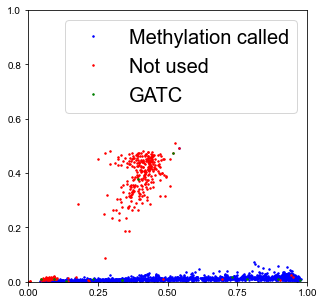

In [16]:
hfont = {'fontname':'Arial'}
# Now plot some 

plt.figure(figsize=(5,5))
plt.plot(posfrac[goodbase], negfrac[goodbase], 'b.', ms=3, label='Methylation called')
plt.plot(posfrac[badbase], negfrac[badbase], 'r.', ms=3, label='Not used')
plt.plot(posfrac[GATC], negfrac[GATC], 'g.', ms=3, label='GATC')
plt.xlim([0,1])
plt.ylim([0,1])
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
#plt.xlabel('Fraction of positive control called as methylated', fontsize=20)
#plt.ylabel('Fraction of negative control called as methylated', fontsize=20)
#plt.title('Cyp3a11 Adenines after training on 20230207')
plt.legend(fontsize=20)
#plt.savefig('/home/cmoore/Cyp3a11_plots_for_paper/FigS_SAMOSA_qc/goodAs' + '.pdf', dpi=300, bbox_inches="tight")

In [17]:
#negative and positive control aIPD residual binarization as methylated or not based on the mixture model thresholds for methylation
#at each adenine. This array isall the aIPDs and it has nans at positions where theres no residual or it's a badbase

methbin = np.full(residuals[1].shape, np.nan, dtype=np.float32)

for b in range(methbin.shape[1]):

    if b in goodbase:
        hasmeasure = ~np.isnan(residuals[1][:,b])
        #print(hasmeasure.shape)
        methbin[hasmeasure,b] = residuals[1][hasmeasure,b] > smmfd['threshold'][b]
        #methbin[hasmeasure,b] = resid[hasmeasure,b] > 0.4

#positive control binarization 
posmethbin = np.full(residuals[0].shape, np.nan, dtype=np.float32)

for b in range(posmethbin.shape[1]):

    if b in goodbase:
        hasmeasure = ~np.isnan(residuals[0][:,b])
        
        posmethbin[hasmeasure,b] = residuals[0][hasmeasure,b] > smmfd['threshold'][b]
      


# Now process sample files using CCS 6.9.99 files as input

In [18]:
#these functions extract reads and ipd information from the ccs filesin batches

import seaborn as sns
from __future__ import print_function, division
import re
import glob
from pysam import AlignmentFile

import smm
from scipy.stats import t
import warnings
from sklearn.exceptions import ConvergenceWarning
import pdb

matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

usepercentiles = range(10,41)
baserc = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
p = re.compile(r'\d+[=XDI]')

# uncompress ipd and pw tags to frames
def _makeFramepoints():
    B = 2
    T = 2**6

    framepoints = []
    next = 0
    for i in range(256//T):
        grain = B**i
        nextOnes = next + grain * np.arange(0, T)
        next = nextOnes[-1] + grain
        framepoints = framepoints + list(nextOnes)
    return np.array(framepoints, dtype=np.uint16)

#make the ipds which are in 50lnIPD + 1 into log10IPD values to match the controls 
_framepoints = _makeFramepoints()
_framepoints_log = (_framepoints - 1)/50
#_framepoints_log = (_framepoints )/50 - (1/50)
#pdb.set_trace()  # Execution will pause here
_framepoints_log=_framepoints_log/np.log(10)


def codeToFrames(code):
    return _framepoints_log[code]


def getSubset(bam_in_name, begin=0, finish=-1):

    bam_in = AlignmentFile(bam_in_name, threads=32)

    subset = []
    for c, read in enumerate(bam_in):
        if c>= finish and finish > 0:
            bam_in.close()
            return subset
        if c<begin:
            continue
        subset.append(read)
    bam_in.close()
    return subset

def ipdExtractor(reads, refFile, outlist, extractIPDmock, zmwlist, goodReads, test_val):
    
    for ir, record in enumerate(SeqIO.parse(refFile, 'fasta')):
        if ir > 0:
            raise InputError('Reference fasta has multiple entries')
        refseq = record.seq
        len_seq = len(record)

   
    

    for c, read in enumerate(reads):
        allipds = np.empty((2, len_seq)) #one row for mean forward ccs ipds, one for rev 
        allipds.fill(np.nan)

        try:
            tags = {"fi":read.get_tag("fi"), "np":read.get_tag("np"),
                "ri":read.get_tag("ri"), "fp":read.get_tag("fp"), "rp":read.get_tag("rp"),
                "zmw":read.get_tag("zm"),   #"bx":read.get_tag("bx"),
                "readlength":len(read.seq)
                }
        
        except KeyError:
            print('key error')
            continue
        except ValueError:
            print('value error')
            continue

        mincov = 10  #minimum number of subreads
        if not tags["np"] >= mincov:
            continue
            
        # if zmwlist:
        #     if tags['zmw'] not in zmwlist:
        #         continue
            
        if len(read.seq) != len(tags['fi']):
            print('check your lima version')
            continue
        else:
            #print('tagsFI, codetoframesFI', read.get_tag("fi"), codeToFrames(tags['fi'] ))
            if read.is_reverse:
                #print('read number:', c, goodReads)
                saveFI = codeToFrames(tags['fi'])
                tags["fi"] = codeToFrames(tags['ri'])
                tags["ri"] = np.flip(saveFI)


            else:
                #pdb.set_trace()  # Execution will pause here
                tags["fi"] = codeToFrames(tags['fi'])
                tags["ri"] = np.flip(codeToFrames(tags['ri']))

            if len(tags["ri"]) < 1 or len(tags["fi"]) < 1: #make sure that this read has ri and fi infomation
                continue
            
            tags["fi"][tags["fi"] < 1] = 1
            tags["ri"][tags["ri"] < 1] = 1
        
            ref_pos = read.get_reference_positions(full_length=True)
           
            
            fbase = list(read.seq)
            offset = 1
            
            #quality control step for aligning reads to reference
            if len(read.get_reference_positions())/len_seq  < 0.81 or len(read.get_reference_positions())/len(read.seq) < 0.85: #only take the highest quality consensus reads 
                continue
            
            
            
           
            for x, pos in enumerate(ref_pos):
                if pos is not None: #meaning that this base aligned to the reference at a certain position, not an insert
                    if pos >= len_seq: continue
                    allipds[0][pos] = tags["fi"][x]
                    allipds[1][pos] = tags["ri"][x]

            #i want one dictionary per zmw
            #cut off allipds to take the 40th A 
            zmwlist.append(tags['zmw'])
            
            if tags["zmw"] == test_val:
                print('extractIPD goodreads id for zmw %s', test_val, goodReads)

            goodReads += 1
            
            outlist[tags["zmw"]] = {'fmean':allipds[0].astype(np.float32), 'rmean':allipds[1].astype(np.float32),'nsubr':tags["np"], 'zmw':tags["zmw"] } 
            
            extractIPDmock.append({'fmean':allipds[0].astype(np.float32), 'rmean':allipds[1].astype(np.float32),
                                               'nsubr':tags["np"], 'zmw':tags["zmw"] } )
            
       
    
    print('total good alignments', goodReads)

    #return(outlist, refseq, extractIPDmock, goodReads) #a list with one dictionary per read
    return(outlist, refseq, extractIPDmock, zmwlist, goodReads)

In [19]:
#extracts IPD values from ccs files. For troubleshooting 

def ipdInspector(fin,  sample):
    batch_size = 10000 #number of reads to process at a time so it doesn't seg fault
    bam_in = AlignmentFile(fin, threads=32)
    total_reads = bam_in.count(until_eof=True)
    print('total reads: ', total_reads)
    bam_in.close()

    if total_reads > 60000: #to limit processing time, can remove 
        total_reads = 60000
    outlist = {}
    extractIPDmock = []

    goodReads = 0


    starting_read = 0
    batches = list(range(starting_read, total_reads, batch_size))
    batches.append(total_reads)
    for n, batch in enumerate(tqdm(batches)):
        if batch == batches[-1]:
            break
        reads = getSubset(fin, batch, batches[n+1]) #list of reads to get tags for
        
        outlist, refseq, extractIPDmock, goodReads = ipdExtractor(reads, refFile, outlist, extractIPDmock, goodReads)

    
    #aipd, abaseInd = getaipds(outlist, refseq)
    
    return extractIPDmock

In [20]:
#USE THIS TO PROCESS CCS 6.9.99 SAMPLE FILES. 
#these functions extract the ipds from ccs files, create an array of ipds, and run the SVD model and NN on the values 


def holeinone_newHMM(sample, db, test_val):
    fin = os.path.join(db, sample)
    batch_size = 10000 #number of reads to process at a time so it doesn't seg fault
    bam_in = AlignmentFile(fin, threads=32)
    total_reads = bam_in.count(until_eof=True)
    print('total reads: ', total_reads)
    bam_in.close()

    zmwlist = []
    goodReads = 0
    outlist = {}
    extractIPDmock = []
    starting_read = 0
    if total_reads > 60000: #for speed
        total_reads = 60000
    
    #total_reads = 1000
    batches = list(range(starting_read, total_reads, batch_size))
    batches.append(total_reads)
    #for n, batch in enumerate(tqdm(batches)):
    for n, batch in enumerate(batches):

        if batch == batches[-1]:
            break
        reads = getSubset(fin, batch, batches[n+1]) #list of reads to get tags for

        print('processing batch %s of %s' % (n+1, len(batches)-1))
        outlist, refseq, extractIPDmock, zmwlist, goodReads = ipdExtractor(reads, refFile, outlist, extractIPDmock, zmwlist, goodReads, test_val)
        #outlist, refseq, extractIPDmock = ipdExtractor(reads, refFile, outlist, extractIPDmock)

    #return outlist, extractIPDmock 
    #now do latentifyNNinput    

    ipds = extractIPDmock

    refis = {n: np.array([b is n for b in refseq]) for n in ['A','C','G','T','X', 'Y']}

    notaFor = np.logical_or.reduce([refis['A'],refis['C'],refis['G']]) #all bases that were not T
    notaRev = np.logical_or.reduce([refis['T'],refis['C'],refis['G']]) #all bases that were not A 

    nfor = np.sum(notaFor)
    nrev = np.sum(notaRev)

    notaipd = np.full((len(ipds), (nfor + nrev)), np.nan, dtype=np.float32)
    print('notaipd', notaipd.shape)

    for i in range(len(ipds)):
        notaipd[i, 0:nfor] = ipds[i]['fmean'][notaFor] #mean is interchangable with ipd, mean of subreads
        #notaFor is a truth array and it indexes fmean to pull all the ipds out that are true

        notaipd[i, nfor:(nfor+nrev)] = ipds[i]['rmean'][notaRev] #plot histogram of ipds at these bases for template_A=refis['T'] 


    notaipd = notaipd - np.nanmean(notaipd, axis=0) #each ipd has the molecule's mean ipd subtracted from it

    indices = np.nonzero(~np.isnan(notaipd)) #returns indices of ipds that are nonzero

    #now use svd model 

    sparsem = coo_matrix( (notaipd[indices], indices), shape=notaipd.shape) 

    sparsem = csr_matrix(sparsem)

    pcvars = isvdmod.transform(sparsem) #keep variables consistent now that model is trained

    stpcvars = pcvars - pcvars.mean(axis=0) 
    stpcvars = stpcvars / stpcvars.std(axis=0)   #normalized variables

    onlyATref = [b for b in refseq if b == 'A' or b == 'T'] 
    refisonly = {n: np.array([b is n for b in onlyATref]) for n in ['A','T']}

    aipd = np.full((len(ipds), len(onlyATref)), np.nan, dtype=np.float32) #empty array with which to enter A and T ipds

    for i in range(len(ipds)):
        aipd[i, refisonly['T']] = ipds[i]['fmean'][refis['T']] 
        aipd[i, refisonly['A']] = ipds[i]['rmean'][refis['A']]

    abaseInd = np.nonzero(np.logical_or(refis['A'], refis['T']))[0] 

    Sampleaipd = aipd #for nontruncated samples
    print(Sampleaipd.shape)
    Samplepred = imodel.predict(stpcvars, batch_size=512) #regardless. This predicts based on the molecule's SVD variables. 

    Sampleresid = Sampleaipd - Samplepred #residuals for nontruncated sample


    #plot a residuals of positive control 
    negmed = []

    for base in range(Sampleresid.shape[1]):
        negmed.append(np.nanmedian(Sampleresid[:,base]))

    negmed = np.array(negmed)

    #binarization
    Samplemethbin = np.full(Sampleresid.shape, np.nan, dtype=np.float32) #start with nan array to fill in with methylation predictions

    for b in range(Samplemethbin.shape[1]):

        if b in goodbase:
            hasmeasure = ~np.isnan(Sampleresid[:,b]) #all molecules that have a measured residual at that base
            Samplemethbin[hasmeasure,b] = Sampleresid[hasmeasure,b] > smmfd['threshold'][b]

    methpreds = Samplemethbin #this will have nans at the bad bases and at rows where there wasnt as residual or it wasn't above the threshold 
    #methpreds = Samplemethbin[:1000] #only do 1000 for quickness 
    
    return methpreds, zmwlist, goodReads

In [ ]:
#only need to run once while training model
# now create an HMM model with an accessible and inaccessible state for every predicted adenine
# Incorporating the probabilities from the negative and positive controls as expectations for methylation being
# predicted in either accessible or inaccessible states

import numba
from numba import njit ## v0.53.1
from numba.typed import Dict
from numba.core import types
from pomegranate import HiddenMarkovModel, State, BernoulliDistribution

#these are binarized methylation predictions at each adenine for positive and negative controls
negmethpred = methbin
posmethpred = posmethbin

def HMMv1_invitro(methPred, goodIndInd, negmprob, posmprob, length=3472, t=1/1000):


    AcAd = []
    InacAd = []

    for ib, b in enumerate(goodIndInd):
        AcAd.append(State(BernoulliDistribution(posmprob[b]), name="Ac_{0}".format(ib)))
        InacAd.append(State(BernoulliDistribution(negmprob[b]), name="Inac_{0}".format(ib)))

    model = HiddenMarkovModel()
    model.add_states(AcAd)
    model.add_states(InacAd)
    model.add_transition(model.start, AcAd[0], 0.5)
    model.add_transition(model.start, InacAd[0], 0.5)

    for b in np.arange(len(goodIndInd)-1):
        dist = abaseInd[goodIndInd[b+1]] - abaseInd[goodIndInd[b]]
        stayInacP = (1 - t)**dist
        model.add_transition(InacAd[b], InacAd[b+1], stayInacP)
        model.add_transition(InacAd[b], AcAd[b+1], 1 - stayInacP)
        stayAcP = (1 - t)**dist
        model.add_transition(AcAd[b], AcAd[b+1], stayAcP)
        model.add_transition(AcAd[b], InacAd[b+1], 1 - stayAcP)

    model.add_transition(AcAd[len(goodIndInd)-1], model.end, 1)
    model.add_transition(InacAd[len(goodIndInd)-1], model.end, 1)
    model.bake()
    
    refbases = np.arange(length)
    hmmRes = np.full((methPred.shape[0], length), np.nan)
    for im in tqdm(range(len(methPred))):
        path = model.viterbi(methPred[im,goodInd])
        pathRes = np.full(len(goodIndInd), np.nan)
        for p in path[1]:
            psplit = p[1].name.split('_')
            if len(psplit) > 1:
                if psplit[0] == 'Ac':
                    pathRes[int(psplit[1])] = 1
                if psplit[0] == 'Inac':
                    pathRes[int(psplit[1])] = 0
        hmmRes[im,:] = np.interp(refbases, goodBase, pathRes)
        
    return hmmRes

def HMMv2_invitro(methPred, goodIndInd, neg, pos, length=3472, t= 1/1000):
    '''
    Function to generate binarized accessibilty calls for multiple molecules using methylation probabilities inferred by NN
    Parameters:
        methPred: array
            An array of methylation predictions where rows are molecules and columns are good A/T bases in the refseq
        
        goodIndInd: 1D array
            Array of positions in the sequence where there are "good" A/Ts, that is, A/Ts that are distinguishable between
            controls
            
        neg: 1D array
            An array of methylation predictions for the negative sample
        
        pos: 1D array
            An array of methylation predictions for the positive sample
        
        t: float
            Transition probability set for the HMM
    Returns:
        binarized_molecules: dict
            A dictionary where keys are ZMW IDs, and values are numpy binarized accessibility arrays.  
    '''
    
    ## Precompute "d", an array for looking up the state transition probabilities 
    ## stayprob=999/1000
    d=np.zeros((2,length)) ## Assume a maximum molecule length of 35kb
    d[0,:]=(1 - t) ** np.arange(length)
    d[1,:]=1 - d[0,:]
    d = np.log(d)
    
    ## Define dict
    binarized_molecules = {}

    for i in tqdm(range(len(methPred))):  #iterate through all molecules A/T methylation predictions
        seqlen = length
        #print("this happens")       
        ## Set up the binarized array outside of the numba function
        ## Fill with NaNs, so values that cannot be inferred are NaN
        binarized_molecules[i]=np.full(
                                shape=seqlen,
                                fill_value=np.nan,
                                dtype=float)
        seq = methPred[i]
        ## Set up the traceback matrix and 
        ## traceback pointer matrix together, outside of the numba function.
        tb=np.zeros((len(methPred[0]),2),dtype=float)
        tb_ptr=np.zeros((len(methPred[0]),2),dtype=int)
        
        ## run the numba function
        _viterbi_v2(
                    goodIndInd,
                    seq,
                    pos,
                    neg,
                    binarized_molecules[i],
                    tb,
                    tb_ptr,
                    d
                   )
        
    return binarized_molecules

@njit
def _viterbi_v2(pos,
                sequence,
                P_M_Ac,
                P_M_InAc,
                path,
                tb,
                tb_ptr,
                d
               ):
    
    '''
    Internal numba function for computing viterbi decoding from methylation probabilites. This function
    does not return any values. It modifies the arrays that are passed to it. This is due to a bug 
    in numba that causes a memory leak if numpy arrays are made within a function and returned. 
    
    Parameters:
        pos : np.array
            (length of sequence) The position of individual adenines for which methylation probabilites have been
            inferred by NN.
        
        P_M_Ac : np.array
            (length of sequence) Numpy array holding the probability of observing methylation at each adenine,
            given sequence context, and that the position was methylated in a positive control
            
        P_M_InAc : np.array
            (length of sequence) Numpy array holding the probability of observing methylation at each adenine,
            given sequence context, and that the position was unmethylated in a negative control 
        
        path : np.array
            (length of sequence ) Numpy array to hold the binarized accessibility values (1,0)
        
        tb : np.array
            (length of sequence x 2) Numpy array to hold intermediate log-likelhoods of InAc and Ac states
        
        tb_ptr : np.array
            (length of sequence x 2) Numpy array to hold traceback decisions betwen InAc and Ac states.
        
        d : np.array
            Precomputed values for the log probability of staying in a given state (ex. InAc --> InAc) or
            leaving a given state (InAc --> Ac), based on the distance between adenines, and an estimated
            probability of staying of 999/1000 per base
    '''

    ## Get the length of the sequence 
    seqlen=sequence.shape[0]

    ## Initialize intermediate arrays
    InAc_vals=np.zeros(2)
    Ac_vals=np.zeros(2)
    
    
    ## set up initial values
    c=sequence[0] ## get first entry
    ## calculate em for Ac / InAc 
    log_05=np.log(0.5)
    tb[0,0]=log_05+np.log(1-c+(2*c-1)*P_M_InAc[0])
    tb[0,1]=log_05+np.log(1-c+(2*c-1)*P_M_Ac[0])

    for i in range(1,seqlen):
        dist = pos[i]-pos[i-1]
        dist_stay =  d[0,dist]#np.log(stayprob**dist)
        dist_leave= d[1,dist]#np.log(1-(stayprob**dist)) #dist_leave=np.log(1-np.exp(dist_stay))

        c=sequence[i] ## 
        l1=1-c
        l2=2*c-1
        
        em_ac=np.log(l1+l2*P_M_Ac[i])  ## P_M|AC
        em_inac=np.log(l1+l2*P_M_InAc[i]) ## P(M|InAc)

        # ## inac_vs_ac model
        InAc_vals[0]=tb[i-1,0]+dist_stay + em_inac ## stay inac, emit inac
        InAc_vals[1]=tb[i-1,1]+dist_leave+em_inac ## switch from Ac, emit inac
        Ac_vals[0]=tb[i-1,0]+dist_leave + em_ac ## switch from Inac , emit Ac
        Ac_vals[1]=tb[i-1,1]+dist_stay + em_ac ## stay Ac, emit ac


        ## explicitly define choosing inacessible vs acessible states 
        if InAc_vals[0]>InAc_vals[1]:
            tb_ptr[i,0]=0
            tb[i,0]=InAc_vals[0]
        else:
            tb_ptr[i,0]=1
            tb[i,0]=InAc_vals[1]

        if Ac_vals[0]>Ac_vals[1]:
            tb_ptr[i,1]=0
            tb[i,1]=Ac_vals[0]
        else:
            tb_ptr[i,1]=1
            tb[i,1]=Ac_vals[1]


    ## Traceback, and simultaenously interpolate to create the binarized vector with 
    ## changepoint probabilties i.e [1,0.5,0,0,0,0.2,0.4,0.6,0.8,1....] 
    ## Choose traceback start based on final output (either accessible / inacessible)
    k = 0 if tb[-1,0] > tb[-1,1] else 1
    
    ## iterate positions backwards, stepsize = 1 --> o
    for o in range(seqlen-1,-1,-1):
        ## Get the current position of an adenine w/ information 
        curpos = pos[o]
        ## Get the position of the "next" adenine w/ information (decrementing position)
        nextpos = pos[o-1]

        ## Record the traceback choice
        path[curpos]=k
        
        ## Use the current value of "k" to select the next value of k 
        k =tb_ptr[o,k]

        ## simulatenously interpolate the rest of the entries in the array 
        ## Set up the problem as linear interpolation between two points
        ## The current position with the current value of k, and the next position w/ the next value of k
        
        
        ## Look foraward to the next position, this is the distance between adenines
        dist = curpos-nextpos
        ## Get difference in values of k (i.e 1-1=0, 0-1=-1, etc.)
        k_dist = path[curpos]-k 
        ## Estimate the slope as change in k, vs change in distance. 
        slope=(k_dist)/(dist)
        
        ## iterate over those enteries and fill in the array
        ## this range statement can only decrement so it wont fill if pos[o-1] goes to the back of the vector
    
        for z in range(curpos-1,nextpos,-1): 
            path[z]= slope*(z-nextpos)+k

#CHANGE this input if changing sequence         
refFile = '/home/cmoore/Cyp3a11_reference.fasta'
    
for ir, record in enumerate(SeqIO.parse(refFile, 'fasta')):
    if ir > 0:
        raise InputError('Reference fasta has multiple entries')
    refseq = record.seq # reference sequence for independent CTCF site


##Values to initialize the emission matrix for the hmm

bins_neg = negmethpred[:1000]
bins_pos = posmethpred[:1000]

# get the indices of adenines where methylation was predicted
goodInd = np.sum(np.isnan(bins_neg), axis=0) < bins_neg.shape[0]

refis = {n: np.array([b is n for b in refseq]) for n in ['A','C','G','T']}
abaseInd = np.nonzero(np.logical_or(refis['A'], refis['T']))[0]

goodBase = abaseInd[goodInd]

goodIndInd = np.nonzero(goodInd)[0]

# Find the probability of each good base being predicted as methylated in negative and positive controls  
pos = np.full((len(abaseInd)), np.nan)
for i in range(len(abaseInd)):
    if goodInd[i]:
        hasmeasure = ~np.isnan(bins_pos[:,i])
        pos[i] = (np.sum(bins_pos[hasmeasure,i] == 1) + .5) / (np.sum(hasmeasure) + .5)

neg = np.full((len(abaseInd)), np.nan)
for i in range(len(abaseInd)):
    if goodInd[i]:
        hasmeasure = ~np.isnan(bins_neg[:,i])
        neg[i] = (np.sum(bins_neg[hasmeasure,i] == 1) + .5) / (np.sum(hasmeasure) + .5)

posmprob = np.full((len(goodBase)), np.nan)
negmprob = np.full((len(goodBase)), np.nan)

for ib, b in enumerate(goodIndInd):
    posmprob[ib] = pos[b]
    negmprob[ib] = neg[b]
        

<ipython-input-21-c562da9e6880>:89: RuntimeWarning: divide by zero encountered in log
  d = np.log(d)
  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1203.37it/s]
<ipython-input-22-0caca6f49dfa>:11: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(mols, axis=0), label='negative control')
<ipython-input-21-c562da9e6880>:89: RuntimeWarning: divide by zero encountered in log
  d = np.log(d)
100%|██████████| 1000/1000 [00:00<00:00, 9318.07it/s]
<ipython-input-22-0caca6f49dfa>:19: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(mols, axis=0), label='positive control')


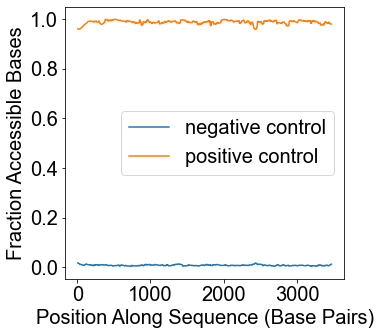

In [22]:

#For visualizing HMM-inferred accessibility across control molecules 

plt.figure(figsize=(5,5))
binarized_molecules = HMMv2_invitro(np.nan_to_num(negmethpred[:1000,goodInd]), goodBase, negmprob, posmprob, length=len(refseq), t= 1/1000)

mols = []
for i in binarized_molecules:
    mols.append(binarized_molecules[i])
mols = np.vstack(mols)

plt.plot(np.nanmean(mols, axis=0), label='negative control')
binarized_molecules = HMMv2_invitro(np.nan_to_num(posmethpred[:1000,goodInd]), goodBase, negmprob, posmprob, length=len(refseq), t= 1/1000)


mols = []
for i in binarized_molecules:
    mols.append(binarized_molecules[i])
mols = np.vstack(mols)
plt.plot(np.nanmean(mols, axis=0), label='positive control')
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.xlabel('Position Along Sequence (Base Pairs)', fontsize=20)
plt.ylabel('Fraction Accessible Bases', fontsize=20)
#plt.title('Cyp3a11 Adenines after training on 20230207')
plt.legend(fontsize=20)
#plt.savefig('/home/cmoore/Cyp3a11_plots_for_paper/FigS_SAMOSA_qc/pos_neg_averages' + '.pdf', dpi=300, bbox_inches="tight")

In [80]:
#for writing out the bam file with the hmm accessibility tags

#add a break statement if old hmm_arr rows is = to the number of reads in the new bamfile 

from array import array
def test(reads, hmm_arr, refFile, bam_out, goodReads, test_val):

    for ir, record in enumerate(SeqIO.parse(refFile, 'fasta')):
        if ir > 0:
            raise InputError('Reference fasta has multiple entries')
        refseq = record.seq
        len_seq = len(record)
    

    for c, read in enumerate(reads):

        try:
            tags = {"fi":read.get_tag("fi"), "np":read.get_tag("np"),
                "ri":read.get_tag("ri"), "fp":read.get_tag("fp"), "rp":read.get_tag("rp"),
                "zmw":read.get_tag("zm"),   #"bx":read.get_tag("bx"),
                "readlength":len(read.seq)
                }
        
        except KeyError:
            print('key error')
            continue
        except ValueError:
            print('value error')
            continue

        mincov = 10  #minimum number of subreads
        if not tags["np"] >= mincov:
            continue
    
        if len(read.seq) != len(tags['fi']):
            continue
        else:

            if len(tags["ri"]) < 1 or len(tags["fi"]) < 1: #make sure that this read has ri and fi infomation
                continue

            #quality control step for aligning reads to reference
            if len(read.get_reference_positions())/len_seq  < 0.81 or len(read.get_reference_positions())/len(read.seq) < 0.85: #only take the highest quality consensus reads 
                continue
            
             #test if we have too many reads
            if goodReads >= hmm_arr.shape[0] -1: #aka the index of goodreads is now the same or larger than the hmm_arr reads, just keep going, these were not used in the paper
                #print('total goodReads:', goodReads+1)
                return goodReads
            
            #now write out the accessibility tag 
            array_to_add = hmm_arr[goodReads]
            old_tags = read.tags
            #print('old tags', old_tags)
            old_tags.append(('sa', array('f', array_to_add) )) #make sure it's float type 
            read.tags = old_tags
            
            bam_out.write(read)

            goodReads += 1

           

    return goodReads
 

In [74]:
#for writing out the bam file with the hmm accessibility tags

#read in the aligned bam without tags to get total reads from fin file 

def bam_writer(sample, db, hmm_arr, refFile, fout, test_val):
    fin = os.path.join(db, sample)
    batch_size = 10000 #number of reads to process at a time so it doesn't seg fault
    bam_in = AlignmentFile(fin, threads=32)
    total_reads = bam_in.count(until_eof=True)
    print('total reads: ', total_reads)

    bam_out = AlignmentFile(fout, "wb", header=bam_in.header, threads = 32)

    bam_in.close()

    starting_read = 0
    goodReads = 0 
    # if total_reads > 60000:
    #     total_reads = 60000
    
    batches = list(range(starting_read, total_reads, batch_size))
    batches.append(total_reads)
    
    
    for n, batch in enumerate(batches):

        print('processing batch %s of %s' % (n+1, len(batches)-1))
        if batch == batches[-1]:
            break
        reads = getSubset(fin, batch, batches[n+1]) #list of reads to get tags for, extracted from the old bam
        
        goodReads = test(reads, hmm_arr, refFile, bam_out, goodReads, test_val) #use the old bam to pull read info and write a new bam with that info + tags
        print('goodReads:', goodReads)

    bam_out.close()


In [25]:
#for checking the bam writer function
from array import array
def unpacker(reads, refFile, tag_arr, zmwlist, goodReads, test_val):

    for ir, record in enumerate(SeqIO.parse(refFile, 'fasta')):
        if ir > 0:
            raise InputError('Reference fasta has multiple entries')
        refseq = record.seq
        len_seq = len(record)
    
    

    for c, read in enumerate(reads):

        try:
            tags = {"fi":read.get_tag("fi"), "np":read.get_tag("np"),
                "ri":read.get_tag("ri"), "fp":read.get_tag("fp"), "rp":read.get_tag("rp"),
                "zmw":read.get_tag("zm"),  'sa':read.get_tag("sa"),  
                "readlength":len(read.seq)
                }
        
        except KeyError:
            print('key error')
            continue
        except ValueError:
            print('value error')
            continue

        mincov = 10  #minimum number of subreads
        if not tags["np"] >= mincov:
            continue
    
        if len(read.seq) != len(tags['fi']):
            continue
        else:

            if len(tags["ri"]) < 1 or len(tags["fi"]) < 1: #make sure that this read has ri and fi infomation
                continue

            #quality control step for aligning reads to reference
            if len(read.get_reference_positions())/len_seq  < 0.81 or len(read.get_reference_positions())/len(read.seq) < 0.85: #only take the highest quality consensus reads 
                continue
            
            #now get the accessibility tag 
            to_add = tags['sa']

            # if goodReads == test_val:
            #     print('zmw:', tags['zmw'])
            #     print('130th element in the 9792nd array added to the bamfile', to_add[130])


            if tags['zmw'] == test_val:

                print('goodReads id for zmw', test_val, goodReads)
                print('130th element in the array added to the bamfile', to_add[130])
            
            
            tag_arr.append(to_add)

            goodReads += 1
            zmwlist.append(tags['zmw'])

    print(goodReads, 'good reads unpacked')
    return tag_arr, zmwlist, goodReads

In [26]:
#for checking the bam writer function by unpacking the tags
def bam_checker(sample, db, refFile, test_val):
    fin = os.path.join(db, sample)
    batch_size = 10000 #number of reads to process at a time so it doesn't seg fault
    bam_in = AlignmentFile(fin, threads=32)
    total_reads = bam_in.count(until_eof=True)
    print('total reads: ', total_reads)
    bam_in.close()

    starting_read = 0
    # if total_reads > 60000: #for speed
    #     total_reads = 60000
   
    tag_arr = [] #array to hold the unpacked tags from the bam file
    zmwlist = []
    goodReads = 0

    batches = list(range(starting_read, total_reads, batch_size))
    batches.append(total_reads)
    
    for n, batch in enumerate(batches):

        if batch == batches[-1]:
            break
        reads = getSubset(fin, batch, batches[n+1]) #list of reads to get tags for
        
        tag_arr, zmwlist, goodReads = unpacker(reads, refFile, tag_arr, zmwlist, goodReads, test_val)
        
    
    return tag_arr, zmwlist
   

In [55]:
for index, row in filtered_data.iterrows():

    if index not in [134]: continue
    
    db = row['aligned_bamfile_base_path']
    f = row['aligned bamfile']
    hmm_arr = row['npy files']
    hmm_path = row['heatmap_base_path']
    hmm_arr = np.load(os.path.join(hmm_path, hmm_arr))

    db2 = db + '/bams_FORPAPER_accessibility_tags/'
    f = row['aligned bamfile']  +'_accTags.bam'
    print(f, db2)
    unpacked_array, zmwlist_fromUnpacking = bam_checker(f, db2, refFile, test_val)

    unpacked = np.vstack(unpacked_array)

    #binarize the hmm arr 
    threshold = 0.5
    hmm_arr_bin = (hmm_arr > threshold).astype(int)

    print('arrays are the same:', np.array_equal(unpacked, hmm_arr_bin)) 


ccs.N10--N10.bam_accTags.bam /home/cmoore/results/pacbio/230720_Hmgb1_acf/ccs_split_cyp3a11/ccs_align/bams_FORPAPER_accessibility_tags/
total reads:  41582
10000 good reads unpacked
20000 good reads unpacked
30000 good reads unpacked
40000 good reads unpacked
41582 good reads unpacked
arrays are the same: True


In [44]:
data_sheet = pd.read_csv('/home/cmoore/PacbioDatasets.csv', sep=',', header=0, index_col=0)
filtered_data = data_sheet[data_sheet['Figure where this data is shown'].notna()]



In [ ]:
#for generating the bams that have the accessibility tags 

varyingT = [1]

test_val = 62522098

for index, row in filtered_data.iterrows():

    #if index not in [351]: continue
    
    db = row['aligned_bamfile_base_path']
    f = row['aligned bamfile']

    db2 = db + '/bams_with_accessibility_tags/'
    

    # Check if the directory exists
    if not os.path.exists(db2):
        os.makedirs(db2)

    print(f)
    binarized_arr, zmwlist, goodReads = holeinone_newHMM(f, db, test_val)


    #now process with the new hmm
    bins_samp = binarized_arr
    for tee in varyingT:
        binarized_molecules = HMMv2_invitro(np.nan_to_num(bins_samp[:,goodInd]), goodBase, negmprob, posmprob, length=len(refseq), t=tee/1000) #no more nans, but still has intermediate values 

        mols = []
        for i in binarized_molecules:
            mols.append(binarized_molecules[i])
        mols = np.vstack(mols)
        

        mols = mols[:,91:] #remove the first 91 bases from the reference alignment, because these bases were digested off of the sequence before sequencing, so theyll show up as nans in the array
        #should not have nans 
        has_nans = np.isnan(mols).any()

        if has_nans:
            print("The array contains NaN values.")
        else:
            print("The array does not contain NaN values.")


        # Define the file path to save zmwlist
        zmwlist_file = os.path.join(db2, f + '_zmwlist.pkl')

        # Save zmwlist to the file
        with open(zmwlist_file, 'wb') as file:
            pickle.dump(zmwlist, file)

        #binarize the accessibility calls before writing tags
        threshold = 0.5
        bin_mols = (mols > threshold).astype(int)

        # print('zmw id and position in zmwlist', test_val, zmwlist.index(test_val))
        # row_id = zmwlist.index(test_val)
        # print('130th element in the %s array added to the bamfile', row_id, bin_mols[row_id][130])

        np.save(db2 + f + '.npy', #save the binarized array 
        arr = bin_mols)
        
        #now write the bam file with the accessibility calls
        fout = os.path.join(db2, f + '_accTags.bam')

        bam_writer(f, db, bin_mols, refFile, fout, test_val)
                        
